# Inference using deployed predictor

Now we are going to use the previously deployed predictor to generate forecasts for the test data and evalute results using differnt techiques.

In [14]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import warnings; warnings.simplefilter('ignore')

%matplotlib inline
session = boto3.Session(region_name='us-east-1') #us-east-1 is also supported

forecast = session.client(service_name='forecast')
forecastquery = session.client(service_name='forecastquery')

In [15]:
project = 'favorita_forecast3' # Replace this with a unique name here, make sure the entire name is < 30 characters.
predictorName= project+'_mqrnn3'

In [16]:
forecast.list_deployed_predictors()

{'PredictorNames': ['acindar_arima',
  'acindar_deeparplus',
  'favorita_forecast3_mqrnn3'],
 'ResponseMetadata': {'RequestId': 'eb157c20-65c1-40e8-b994-e4bcabe0d1d6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 12 Mar 2019 13:04:32 GMT',
   'x-amzn-requestid': 'eb157c20-65c1-40e8-b994-e4bcabe0d1d6',
   'content-length': '85',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [17]:
df = pd.read_csv('target_time_series.csv',header=None)
df.columns=  ['Item','Date','Value']

In [18]:
df.head()

,Item,Date,Value
0,96995,2013-02-04,1.0
1,96995,2013-02-05,0.0
2,96995,2013-02-06,0.0
3,96995,2013-02-07,0.0
4,96995,2013-02-08,0.0


In [19]:
df['Date'] = pd.to_datetime(df['Date'])

In [20]:
unique_items = df['Item'].unique()

### 1. Filter the products and predict

We are not going to take into account for evaluation products that have less than 10 days of data for testing.
We use the get_forecast method ti request predictions for each item.

In [21]:
def max_date_of_item(item):
    return df[df['Item']==item]['Date'].max()

In [25]:
results = []
for item in unique_items:
    try:
        if max_date_of_item(item) >= pd.Timestamp(2017,8,10):
            forecastResponse = forecastquery.get_forecast(
                PredictorName=predictorName,
                Interval="day",
                Filters={"item_id":str(item)}
            )
            results.append({'forecast':forecastResponse['Forecast'],'item_id':item})
    except:
        pass



In [26]:
print(len(results))
#print(results[1])

2620


### 2. Plot predictions agains ground thruth

In [32]:
def plot_preds_against_truth(i):
    
    df_res = pd.DataFrame(results[i]['forecast']['Predictions']['p50'])
    id_item = results[i]['item_id']
    df_res['Date'] = pd.to_datetime(df_res['Date'])
    df_truth = df[df.iloc[:,0]==id_item].copy()
    df_truth.columns = ['Item','Date','Value']
    df_truth['Date'] = pd.to_datetime(df_truth['Date']) 

    df_truth = df_truth[df_truth['Date'] > pd.Timestamp(2017,6,1)]
    df_truth = df_truth.merge(df_res,how='left',on='Date')

    df_truth.set_index('Date',inplace=True)
    plt.figure(figsize=(12,5))
    plt.xlabel('True and predicted sales')

    ax1 = df_truth['Value'].plot(color='blue', grid=True, label='True')
    ax2 = df_truth['Val'].plot(color='red', grid=True, secondary_y=True, label='Predicted')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()


    plt.legend(h1+h2, l1+l2, loc=2)
    plt.show()

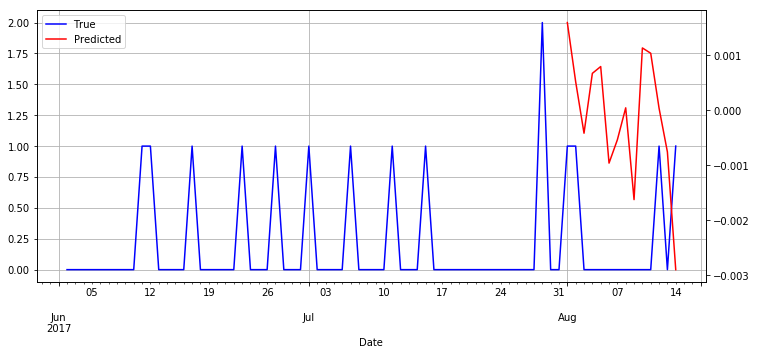

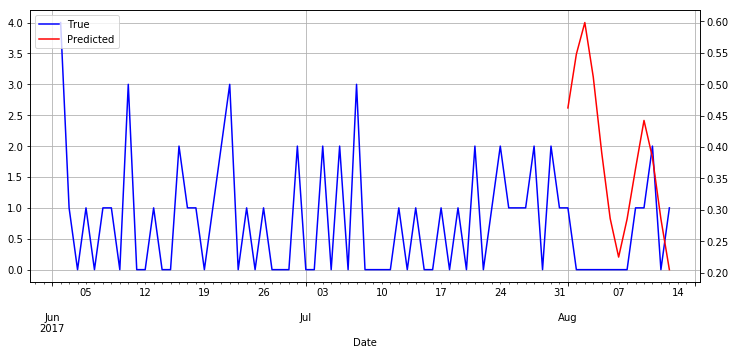

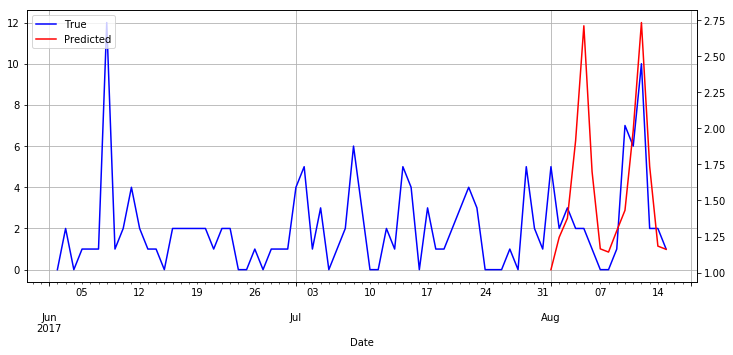

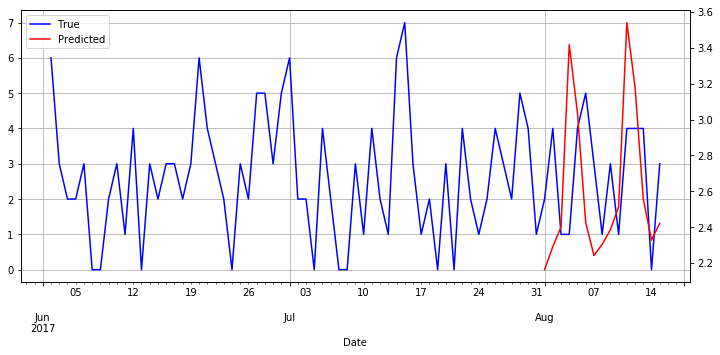

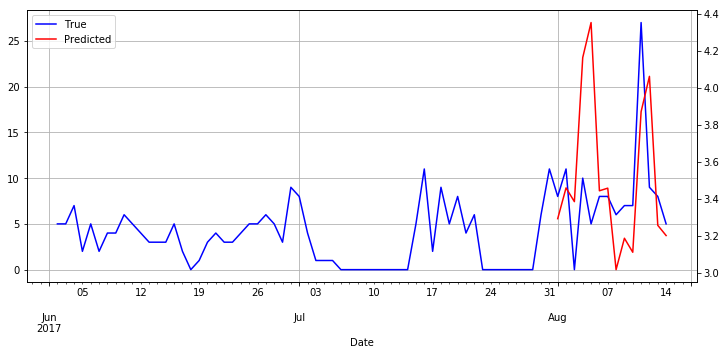

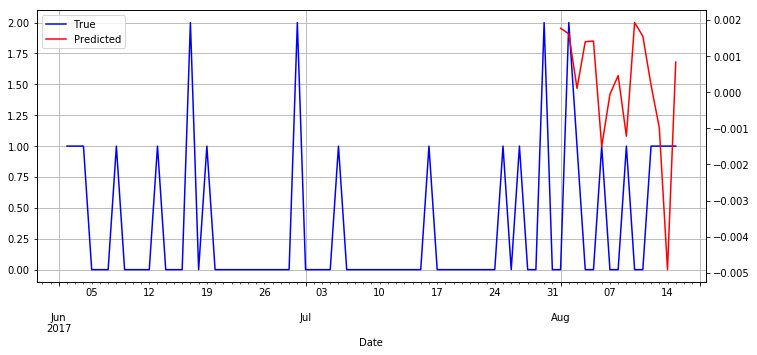

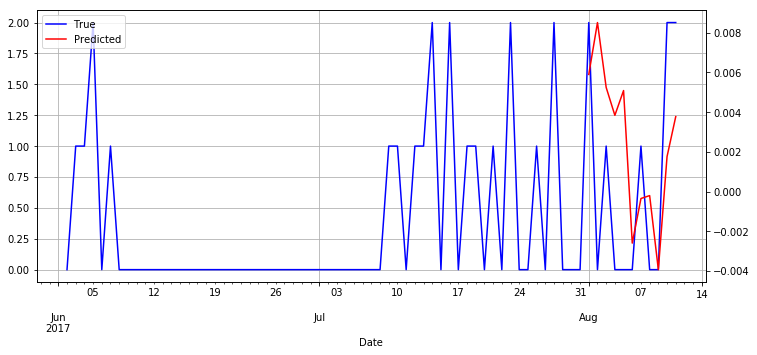

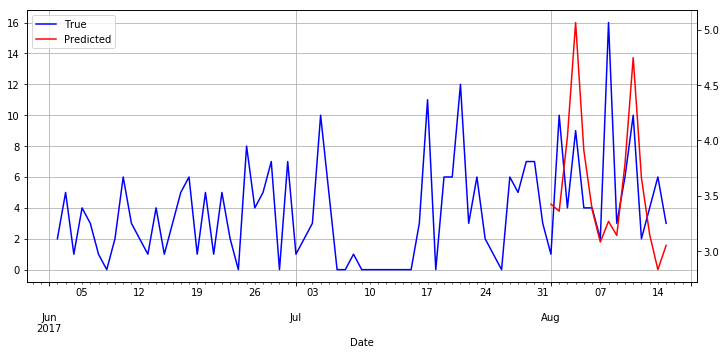

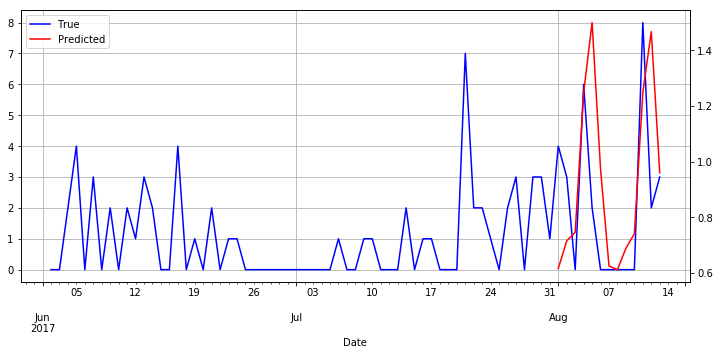

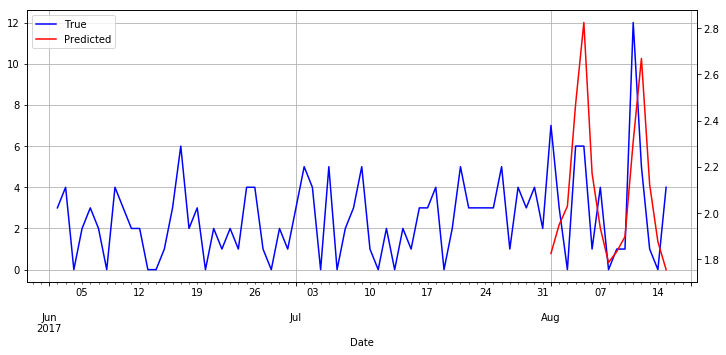

In [33]:
for i in range(10):
    plot_preds_against_truth(i)

### 3. Evaluate mae 

The best metric to evaluate a forecast is rmse or mae. Mae meassures the average error on each series, wich gives us an idea of the deviation in product units. But how do we know the forecast is a good? The best way is to compare it with the random walk trivial solution which consists in forecasting the last available value.
A way to standarize mae between series of products that may have a different scale is to use the min-max standarization.

In [67]:
def get_last_value(df_truth,min_pred_date):
    
    df_last = df_truth[(df_truth['Date'] < min_pred_date) & (df_truth['Value'] > 0) ].sort_values('Date',ascending=False).head(1)
    return df_last.iloc[0,2]

In [74]:
def computePercentageError(i):
    df_res = pd.DataFrame(results[i]['forecast']['Predictions']['p50'])
    id_item = results[i]['item_id']
    df_res['Date'] = pd.to_datetime(df_res['Date'])
    df_truth = df[df.iloc[:,0]==id_item].copy()
    df_truth.columns = ['Item','Date','Value']
    df_truth['Date'] = pd.to_datetime(df_truth['Date']) 
    
    max_val = df_truth['Value'].max()
    min_val = df_truth['Value'].min()

    max_pred_date = df_truth['Date'].max()
    min_pred_date = df_res['Date'].min()
    
    las_value_avail = get_last_value(df_truth,min_pred_date)

    df_truth = df_truth[df_truth["Date"]>=min_pred_date]
    df_res = df_res[df_res["Date"]<=max_pred_date]
    df_res['Val'] = df_res['Val'].apply(lambda x: 0 if x<0 else x)

    r = pd.date_range(start=min_pred_date, end=max_pred_date)
    df_truth = df_truth.set_index('Date').reindex(r).fillna(0.0).rename_axis('Date').reset_index()

    if max_val == min_val:
        raise AssertionError("No variability in series")
    mae = np.sum(np.abs(df_res['Val'] - df_truth['Value']))/df_res.shape[0]
    trivial_mae = np.sum(np.abs(df_res['Val'] - las_value_avail))/df_res.shape[0]

    return {'mae':mae/(max_val - min_val),
            'trivial_mae':trivial_mae/(max_val - min_val),
            'item':id_item}

In [75]:
accuracy = []
for i in range(len(results)):
    try:
        accuracy.append(computePercentageError(i))
    except:
        pass

In [76]:
pd.options.display.float_format = '{:.2f}'.format

In [77]:
final_error = pd.DataFrame(accuracy).dropna()

In [78]:
final_error['mae'].mean() # Model MAE

0.08116616888286599

In [79]:
final_error['trivial_mae'].mean() # Random walk MAE

0.11118926142817825

In [41]:
final_error.sample(10)

,item,mae,trivial_mae
205,279137,0.12,0.00
1340,1239739,0.09,0.06
559,617092,0.10,0.04
1325,1230003,0.03,0.00
1733,1463441,0.09,0.00
1457,1313222,0.08,0.15
418,470625,0.11,0.00
1651,1453124,0.11,0.06
170,262358,0.03,0.02
1326,1230244,0.03,0.00


### 4.Cleanup

If you are not going to use the deployed predictor anymore, you can delete it.

In [ ]:

# project = 'favorita_forecast2' # Replace this with a unique name here, make sure the entire name is < 30 characters.
# predictorName= project+'_mqrnn2'

# # Delete Deployed Predictor 
# forecast.delete_deployed_predictor(PredictorName=predictorName)



# # Delete the Predictor: 
# forecast.delete_predictor(PredictorName=predictorName)


# datasetGroupName= project +'_gp2'


# # Delete Import
# #forecast.delete_dataset_import(DatasetName='datasetName')


# forecast.list_predictors()

# forecast.delete_predictor(PredictorName='favorita_forecastdemo_mqrnn2')

# forecast.delete_dataset(DatasetName='favorita_forecastdemo_dssimple')


# # Delete Dataset Group
# forecast.delete_dataset_group(DatasetGroupName=datasetGroupName)